# PROJECT 1

First let's import the reviews

In [13]:
import pandas as pd
reddit_data = pd.read_csv("./archive/Reddit_Data.csv")
twitter_data = pd.read_csv("./archive/Twitter_data.csv")
print(reddit_data.head(5))
print(twitter_data.head(5))

                                       clean_comment  category
0   family mormon have never tried explain them t...         1
1  buddhism has very much lot compatible with chr...         1
2  seriously don say thing first all they won get...        -1
3  what you have learned yours and only yours wha...         0
4  for your own benefit you may want read living ...         1
                                          clean_text  category
0  when modi promised “minimum government maximum...      -1.0
1  talk all the nonsense and continue all the dra...       0.0
2  what did just say vote for modi  welcome bjp t...       1.0
3  asking his supporters prefix chowkidar their n...       1.0
4  answer who among these the most powerful world...       1.0


DA


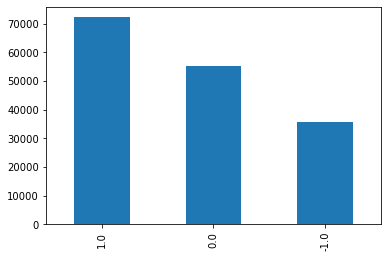

In [14]:
import matplotlib.pyplot as plt
print("DA")
fig, ax = plt.subplots()
twitter_data['category'].value_counts().plot(ax=ax, kind='bar')
plt.show()

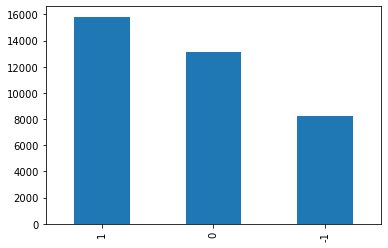

In [15]:
fig, ax = plt.subplots()
reddit_data['category'].value_counts().plot(ax=ax, kind='bar')
plt.show()

In [16]:
def get_input(datafr, col_name = "clean_comment"):
    X = []
    Y = []
    for i in range(0, int(datafr.size/2)):
        text = datafr[col_name][i]
        X.append(text)
        nr = datafr['category'][i]
        if nr != 0 and nr != 1:
            nr = 2
        Y.append(nr)
    return X, Y

X1, Y1 = get_input(reddit_data, col_name = "clean_comment")
X2, Y2 = get_input(twitter_data, col_name = "clean_text")
X = X1 + X2
Y = Y1 + Y2
print(X[3])
print(Y[3])

what you have learned yours and only yours what you want teach different focus the goal not the wrapping paper buddhism can passed others without word about the buddha 
0


Now we preprocces the text data (we clean the text out of punctuations, stop words and lowercase every letter)

In [17]:
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

def preprocess_data(text_list):

    import ssl

    try:
        _create_unverified_https_context = ssl._create_unverified_context
    except AttributeError:
        pass
    else:
        ssl._create_default_https_context = _create_unverified_https_context

    nltk.download('punkt')
    nltk.download('stopwords')

    for i in range(0, len(text_list)):
        text_list[i] = str(text_list[i])
        text_list[i] = text_list[i].translate(str.maketrans('', '', string.punctuation))
    stops = set(stopwords.words('english'))
    clean_list = []
    for text in text_list:
        tokenized_text = [word for word in word_tokenize(text) if word not in stops]
        new_text = ""
        begin = True
        for token in tokenized_text:
            if begin == True:
                new_text = token
                begin = False
            else:
                new_text = new_text + " " + token
        clean_list.append(new_text)
        
    return clean_list


X = preprocess_data(X)
print(X[1:3])

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/andreipetrescu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/andreipetrescu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['buddhism much lot compatible christianity especially considering sin suffering almost thing suffering caused wanting things want going getting things wrong way christian would mean wanting things coincide god wanting things coincide without aid jesus buddhism could also seen proof god mighty omnipotence certainly christians lucky one christ side everyone else well many christians believe god grace salvation buddhism god way showing grace upon others would also help study things jesus said see buddha made similar claims rich man getting heaven joke basically advocating rid material possessions fact distinctly remembered jesus making someone cry someone asked achieve salvation jesus replied live like buddhist roughly translated also point buddha rarely spoke anything god theory personally knew well enough leave jesus mohamed came later remember conflict difference opinion education fun involving enlightening easier teach something prove right like intelligent design', 'seriously say th

Convert the input text into word embeddings

In [18]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 5000
encoded_X = [one_hot(text, vocab_size) for text in X]
max_length = 255
embedded_X = pad_sequences(encoded_X, maxlen = max_length, padding = 'post')
print(embedded_X)

[[1599 1028 1933 ...    0    0    0]
 [1373 1375 1625 ...    0    0    0]
 [ 877 1040 2291 ...    0    0    0]
 ...
 [4124 3612  288 ...    0    0    0]
 [1017  539 4083 ...    0    0    0]
 [3464 4100  632 ...    0    0    0]]


Creating the model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Embedding, Dense, Dropout
from tensorflow.keras.metrics import Accuracy, Precision, Recall
from tensorflow.keras.optimizers import Adam

def create_model(vocab_size, max_length):
    model = Sequential()
    model.add(Embedding(vocab_size, 8, input_length=max_length))
    model.add(Flatten())
    model.add(Dense(8, activation='relu'))
    model.add(Dense(4, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    opt = Adam(learning_rate = 0.001)
    model.compile(loss = 'categorical_crossentropy', optimizer=opt, metrics=['accuracy', Precision(), Recall()])
    return model


Splitting data

In [20]:
import numpy as np

def split_data(X, Y):
    #X = X[:int(len(Y)/10)]
    #Y = Y[:int(len(Y)/10)]
    p = 80
    size = len(Y)
    X_train = []
    Y_train = []
    for i in range(0, int((p*size)/100)):
        X_train.append(X[i])
        Y_train.append(Y[i])
    X_train = np.array(X_train)
    Y_train = np.array(Y_train)
    
    X_test = []
    Y_test = []
    for i in range(int((p*size)/100), size):
        X_test.append(X[i])
        Y_test.append(Y[i])
    X_test = np.array(X_test)
    Y_test = np.array(Y_test)
    
    return X_train, Y_train, X_test, Y_test

X_train, Y_train, X_test, Y_test = split_data(embedded_X, Y)
print(X_train.shape)
print(Y_train.shape)
        

(160183, 255)
(160183,)


Training phase

In [ ]:
from sklearn.model_selection import KFold
from tensorflow.keras.utils import to_categorical

inputs = np.concatenate((X_train, X_test), axis = 0)
targets = np.concatenate((Y_train, Y_test), axis = 0)
targets = to_categorical(targets)
#print(targets)

nr_folds = 3
kfold = KFold(n_splits=nr_folds, shuffle=True)
cr_fold = 1

epochs = 15
batch_size = 15

acc_per_fold = []
precision_per_fold = []
recall_per_fold = []
loss_per_fold = []

for train, test in kfold.split(inputs, targets):
    model = create_model(vocab_size, max_length)
    
    print("Training fold number: " + str(cr_fold) + "...")
    history = model.fit(inputs[train], targets[train], batch_size = batch_size, epochs = epochs)
    scores = model.evaluate(inputs[test], targets[test], verbose=0)
    print(scores)
    
    recall_per_fold.append(scores[3] * 100)
    precision_per_fold.append(scores[2] * 100)
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    
    cr_fold = cr_fold + 1


In [ ]:
print("Average scores:")
print("Accuracy: " + str(np.mean(acc_per_fold)))
print("Precision: " + str(np.mean(precision_per_fold)))
print("Recall: " + str(np.mean(recall_per_fold)))
print("Loss: " + str(np.mean(loss_per_fold)))
print("--------------------------------")
print("Scores per fold")
for i in range(0, len(acc_per_fold)):
    print("Fold: " + str(i+1))
    print("Accuracy: " + str(acc_per_fold[i]))
    print("Precision: " + str(precision_per_fold[i]))
    print("Recall: " + str(recall_per_fold[i]))
    print("Loss: " + str(loss_per_fold[i]))
    print("--------------------------------")

Testing

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Andrei\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Andrei\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['good dogs']
[[3351, 713]]
[2.2974650e-10 9.9583876e-01 4.1612303e-03]


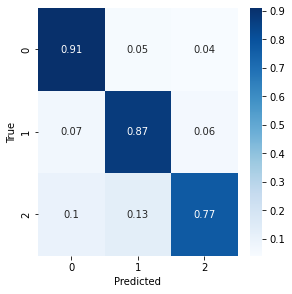

In [31]:
input_text = 'good dogs'

input_text = [input_text]
input_text = preprocess_data(input_text)
print(input_text)
vocab_size = 5000
encoded_input = [one_hot(text, vocab_size) for text in input_text]
print(encoded_input)
max_length = 255
embedded_input = pad_sequences(encoded_input, maxlen = max_length, padding = 'post')
pred = model.predict(embedded_input)

print(pred[0])

import seaborn as sns
import tensorflow as tf
classes = [0, 1, 2]
y_pred = model.predict(X_test)
y_pred = np.round(y_pred).astype(int)
labels = []
for i in range(0, len(y_pred)):
    ok = 0
    for j in range(0, 3):
        if(y_pred[i][j] != 0):
            labels.append(j)
            ok = 1
    if ok == 0:
        labels.append(0)
y_pred = labels

con_mat = tf.math.confusion_matrix(labels=Y_test, predictions = y_pred).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals = 2)
con_mat_df = pd.DataFrame(con_mat_norm, index = classes, columns = classes)

figure = plt.figure(figsize=(4, 4))
sns.heatmap(con_mat_df, annot=True, cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel("True")
plt.xlabel("Predicted")
plt.show()


In [46]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from tqdm import tqdm
from sklearn.model_selection import KFold

vectorizer = CountVectorizer()
inputs = vectorizer.fit_transform(X)


#print(inputs[:5])
targets = np.concatenate((Y_train, Y_test), axis = 0)

nr_folds = 5
kfold = KFold(n_splits=nr_folds, shuffle=True)

acc_per_fold = []
precision_per_fold = []
recall_per_fold = []

cr_fold = 1

for train, test in kfold.split(inputs, targets):
    
    knn = KNeighborsClassifier(n_neighbors=3)
    print("Training fold number: " + str(cr_fold) + "...")
    knn.fit(inputs[train], targets[train])
    
    y_all_pred = knn.predict(inputs[test])

    recall_per_fold.append(recall_score(targets[test], y_all_pred, average='macro'))
    precision_per_fold.append(precision_score(targets[test], y_all_pred, average='macro'))
    acc_per_fold.append(accuracy_score(targets[test], y_all_pred))
    
    cr_fold = cr_fold + 1



Training fold number: 1...
Training fold number: 2...
Training fold number: 3...
Training fold number: 4...
Training fold number: 5...


In [47]:
print("Average scores:")
print("Accuracy: " + str(np.mean(acc_per_fold)))
print("Precision: " + str(np.mean(precision_per_fold)))
print("Recall: " + str(np.mean(recall_per_fold)))
print("--------------------------------")
print("Scores per fold")
for i in range(0, len(acc_per_fold)):
    print("Fold: " + str(i+1))
    print("Accuracy: " + str(acc_per_fold[i]))
    print("Precision: " + str(precision_per_fold[i]))
    print("Recall: " + str(recall_per_fold[i]))
    print("--------------------------------")

Average scores:
Accuracy: 0.5150902157362335
Precision: 0.6985025818330707
Recall: 0.49193009490623807
--------------------------------
Scores per fold
Fold: 1
Accuracy: 0.5187034909853668
Precision: 0.696108628083065
Recall: 0.49375026440297126
--------------------------------
Fold: 2
Accuracy: 0.5104130250212255
Precision: 0.6943495109316143
Recall: 0.49073593138246846
--------------------------------
Fold: 3
Accuracy: 0.5138590620786097
Precision: 0.7008264569118712
Recall: 0.49059949168795053
--------------------------------
Fold: 4
Accuracy: 0.5185786345702442
Precision: 0.6933126786246461
Recall: 0.4934897989975813
--------------------------------
Fold: 5
Accuracy: 0.513896866025721
Precision: 0.7079156346141566
Recall: 0.4910749880602187
--------------------------------


In [49]:
x = ['input to be classified']
x = vectorizer.transform(x)
pred = knn.predict(x)
print(pred)

[2.]


In [12]:
import pydot
model = create_model(5000, 255)
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


model.summary()

In [9]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 255, 8)            40000     
_________________________________________________________________
flatten_4 (Flatten)          (None, 2040)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 16328     
_________________________________________________________________
dense_13 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_14 (Dense)             (None, 3)                 15        
Total params: 56,379
Trainable params: 56,379
Non-trainable params: 0
_________________________________________________________________
